In [ ]:
!pip install datasets
!pip install transformers
!pip install evaluate
!pip install -U sentence-transformers

In [ ]:
from datasets import Dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModel
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from evaluate import load
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')
root = "/content/drive/My Drive/Ara Dönem Proje Fake News Detection/Verisetleri"
#dataset name
file_name = "dataset_bert.csv"
df = pd.read_csv(f"{root}/{file_name}")

Mounted at /content/drive


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df

,text,label
0,i̇çişleri bakanlığı fetö elebaşı gülen hdp'li ...,True
1,türk silahlı kuvvetleri tarafından deaş başta ...,True
2,farkında olmadan evinde flash tv'yi açık unuta...,FAKE
3,hilal sarı / i̇stanbul 4 aralık (dha) – 04.12....,True
4,videonun i̇stanbul'da zikir çeken insanları gö...,FAKE
...,...,...
25152,bursa'nın nilüfer ilçesinde boya fabrikasında ...,True
25153,kaza bahçelievler'de meydana geldi. edinilen b...,True
25154,koru mahallesi'nde 6 dönüm arazi kiralayan ali...,True
25155,rtük erken boşalmayla sonuçlanan sevişme sahne...,FAKE


In [ ]:
#Label Encoder 
label_to_id = {"True":1,"FAKE":0}
id_to_label = {0:"FAKE", 1:"True"}
num_labels = len(label_to_id)
label_to_id

{'True': 1, 'FAKE': 0}

In [ ]:
df.rename(columns = {'label':'class'}, inplace = True)

In [ ]:
dataset = Dataset.from_pandas(df)

In [ ]:
#Turkce dataset icin tokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    tokenized = tokenizer(examples["text"], max_length = 128, padding = "max_length", truncation = True)
    return {"input_ids": tokenized.input_ids, "token_type_ids": tokenized.token_type_ids,
            "attention_mask": tokenized.attention_mask, "labels": [label_to_id[label] for label in examples["class"]]}

In [ ]:
#tokanizer olmus dataset
tokenized_datasets = dataset.map(tokenize_function, batched = True)
tokenized_datasets.set_format("torch")

  0%|          | 0/26 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets

Dataset({
    features: ['text', 'class', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 25157
})

In [ ]:
dataloader = torch.utils.data.DataLoader(tokenized_datasets, batch_size = 32)

In [ ]:
for batch in dataloader:
  break
batch["labels"]

tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 1])

In [ ]:
#Turkce dataset icin model 
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to("cuda")

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [ ]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
X = []
y = []
with torch.no_grad():
  for batch in dataloader:
    X.append(model(batch["input_ids"].to("cuda"), batch["attention_mask"].to(device), batch["token_type_ids"].to(device)).pooler_output.cpu())
    y.extend(batch["labels"].tolist())

In [ ]:
X = torch.concatenate(X[:-1], axis = 0).tolist()

In [ ]:
y = y[:-5]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Text(0.5, 1.0, 'Dataset labels distribuition')

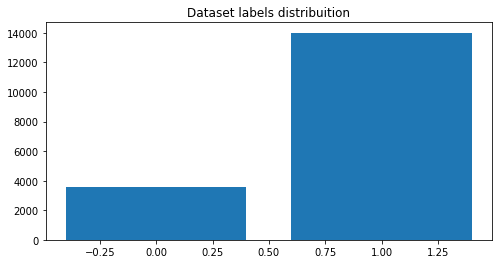

In [ ]:
target_cnt = Counter(y_train)

plt.figure(figsize=(8,4))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
from imblearn.over_sampling import SMOTE

def smote(x, y):
    smote = SMOTE(sampling_strategy= 1, random_state=42)
    x, y = smote.fit_resample(x, y)
    return x, y

In [ ]:
X_train, y_train = smote(X_train, y_train)

Text(0.5, 1.0, 'Dataset labels distribuition')

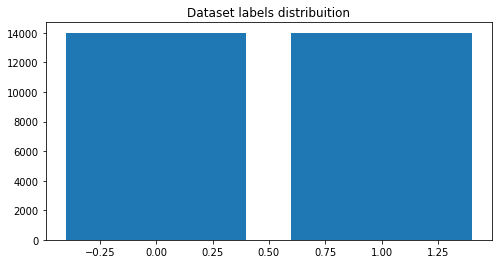

In [ ]:
target_cnt = Counter(y_train)

plt.figure(figsize=(8,4))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

# Classification Methods

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
def predict(sentence, classifier):
  inputs = tokenizer(sentence, max_length = 128, padding = "max_length", truncation = True, return_tensors = "pt")
  with torch.no_grad():
    X = model(inputs["input_ids"].to(device), inputs["attention_mask"].to(device), inputs["token_type_ids"].to(device)).pooler_output.cpu().tolist()
  
  return classifier.predict(X)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1561
           1       0.98      0.97      0.97      5985

    accuracy                           0.96      7546
   macro avg       0.93      0.94      0.94      7546
weighted avg       0.96      0.96      0.96      7546



In [ ]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1561
           1       0.98      0.99      0.98      5985

    accuracy                           0.97      7546
   macro avg       0.97      0.96      0.96      7546
weighted avg       0.97      0.97      0.97      7546



In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.90      0.67      1561
           1       0.97      0.79      0.87      5985

    accuracy                           0.81      7546
   macro avg       0.75      0.85      0.77      7546
weighted avg       0.88      0.81      0.83      7546



In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      1561
           1       0.96      0.91      0.93      5985

    accuracy                           0.90      7546
   macro avg       0.84      0.88      0.86      7546
weighted avg       0.91      0.90      0.90      7546



In [ ]:
predict("Tarım ve Orman Bakanlığının, Twitter hesabından yapılan paylaşıma göre, DSİ’nin merkez ve taşra teşkilatında, 657 sayılı Devlet Memurları Kanunu’nun 4/B maddesi kapsamında istihdam edilmek üzere, çeşitli branşlarda toplam 1273 sözleşmeli personel alımı yapılacak.", nb)

array([1])

In [ ]:
predict("Avrupa İstatistik Ofisi (Eurostat) ve Knight Frank’e ait verilere göre Türkiye, 2022’de Avrupa’da ve dünyada konut fiyatlarının en düşük seviyede olan ülke.", svc)

array([0])

In [ ]:
predict("Lozan'ın Bitişiyle Boş Arazilere Akın Eden Vatandaşların ''Petrolü Kim Çıkaracak?'' Kavgasında Kazma ve Kürekler Konuştu: 116 Yaralı...", nb)

array([0])

In [ ]:
predict("Mevsim Normallerinin Üzerinde Seyreden Hava Sıcaklıklarının, Ocak'tan İtibaren Faturalara ''Küresel Isınma Hizmet Bedeli'' Olarak Yansıtılacağı Açıklandı..",lr)

array([0])

In [ ]:
predict("Resmi Kyodo ajansına göre Hong Kong bandıralı 6 bin 551 tonluk 'Jintan' kargo gemisi Nagazaki açıklarında battı",knn)

array([1])

In [ ]:
predict("Meclis’te memur ve emekliye yüzde 30 zammı içeren kanun teklifi görüşmesi yapılamadan Genel Kurul kapandı. Vekiller Meclis’e gelmeyince karar yeter sayısı bulunamadı ve yasanın görüşmesi yarına kaldı.", knn)

array([1])

In [ ]:
predict("Videonun Kolombiya’daki zombi insanı gösterdiği iddiası",svc)

array([0])

In [ ]:
predict("Acun ılıcalı geçirdiği trafik kazası sonucu ağır yaralandı.", svc)

array([0])

In [ ]:
predict("")

# SBertForSequenceClassification

In [ ]:
# #Turkce dataset icin model 
# model = AutoModelForSequenceClassification.from_pretrained("sentence-transformers/all-MiniLM-L6-v2", classifier_dropout = 0.1, num_labels = num_labels)

In [ ]:
#model output path
# path_output = 'path'
# training_args = TrainingArguments(output_dir = path_output, evaluation_strategy = "epoch", per_device_train_batch_size = 32,
#                                   per_device_eval_batch_size = 32, weight_decay = 0.01, num_train_epochs = 4, save_strategy = "epoch")

In [ ]:
# metric = load('accuracy')

In [ ]:
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = argmax(logits, axis = -1)
#     out_file.write(classification_report(labels, predictions) + "\n\n\n")
#     confusion_matrices.append(confusion_matrix(labels, predictions, labels = list(id_to_label.keys())))
#     return metric.compute(predictions = predictions, references = labels)

In [ ]:
# trainer = Trainer(model = model,
#                   args = training_args,
#                   train_dataset = tokenized_datasets["train"],
#                   eval_dataset = tokenized_datasets["test"],
#                   compute_metrics = compute_metrics)

In [ ]:
# #classification reportlari yazdigi dosya
# with open(f"{root}/result2-sbert-dataset-bert-smote.txt", 'w') as out_file:
#     confusion_matrices = []
#     trainer.train()

In [ ]:
# for cf in confusion_matrices:
#     print(cf)

In [ ]:
# #save model
# trainer.save_model(output_dir='/content/drive/MyDrive/')